In [1]:
from torcheeg.datasets import SEEDDataset
from torcheeg import transforms

raw_dataset = SEEDDataset(
    root_path='./SEED/SEED_EEG/Preprocessed_EEG',
    io_path = 'E:/FYP/Egg-Based Emotion Recognition/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS',
    online_transform=None,  # Disable transforms
    label_transform=None,
    num_worker=4
)

raw_sample = raw_dataset[0]
print(f"Raw EEG data shape: {raw_sample[0].shape}")  # Should be [62, ...] for SEED

[2024-12-04 02:23:29] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from E:/FYP/Egg-Based Emotion Recognition/EEg-based-Emotion-Recognition/.torcheeg/datasets_1733174610032_5iJyS.


Raw EEG data shape: (62, 200)


In [2]:
print(raw_dataset[0])

(array([[-19.28210258,  -9.29832458, -25.77900887, ..., -15.55681229,
        -17.49396324, -19.90795135],
       [ 11.92092896,  20.53380013,  11.41428947, ...,   3.21865082,
         -1.16229057,  13.76867294],
       [  0.56624413,  18.80526543, -11.08646393, ..., -26.4942646 ,
        -23.66304398,   8.31484795],
       ...,
       [  3.4570694 ,  10.72883606,  -6.7949295 , ...,  12.54677773,
         10.46061516,  14.42432404],
       [  5.24520874,  11.77191734,  -3.66568565, ...,  15.07997513,
         11.41428947,  20.02716064],
       [  9.08970833,   6.34789467,   1.16229057, ...,  10.37120819,
         12.54677773,  17.94099808]]), {'start_at': 0, 'end_at': 200, 'clip_id': '10_20131130.mat_0', 'subject_id': 10, 'trial_id': 'ww_eeg1', 'emotion': 1, 'date': 20131130, '_record_id': '_record_0'})


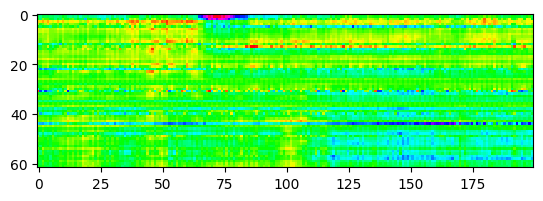

In [4]:
import torch
from torcheeg.utils import plot_2d_tensor

img = plot_2d_tensor(torch.tensor(raw_dataset[0][0]))

In [5]:
import numpy as np
from scipy.signal import butter, lfilter

# Define a bandpass filter (4-47 Hz for SEED dataset)
def bandpass_filter(data, lowcut=4, highcut=47, fs=200, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data, axis=-1)

# Apply bandpass filtering to the raw EEG data
preprocessed_data = bandpass_filter(raw_sample[0])

print(f"Preprocessed EEG data shape: {preprocessed_data.shape}")


Preprocessed EEG data shape: (62, 200)


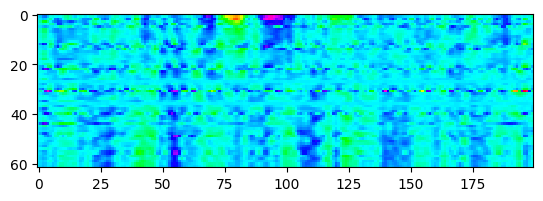

In [8]:
img = plot_2d_tensor(torch.tensor(preprocessed_data))

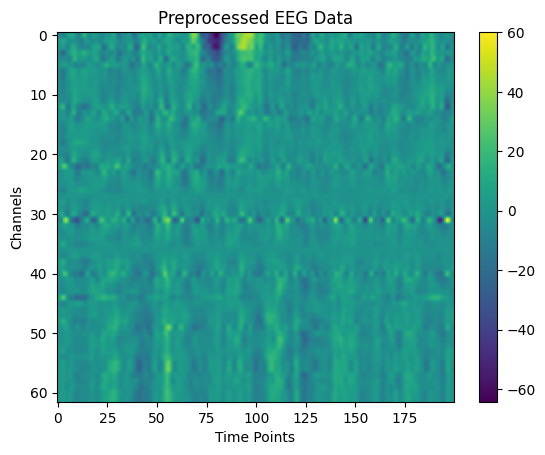

In [9]:
import matplotlib.pyplot as plt

# Visualize the preprocessed EEG data
plt.imshow(preprocessed_data, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Preprocessed EEG Data')
plt.xlabel('Time Points')
plt.ylabel('Channels')
plt.show()


In [10]:
# Perform stratified normalization (z-score)
def stratified_normalization(data):
    normalized_data = (data - np.mean(data, axis=-1, keepdims=True)) / np.std(data, axis=-1, keepdims=True)
    return normalized_data

# Normalize the preprocessed EEG data
normalized_data = stratified_normalization(preprocessed_data)

print(f"Normalized EEG data shape: {normalized_data.shape}")


Normalized EEG data shape: (62, 200)


In [12]:
import torch

def data_sampler(dataset , time_length=30 , step_size=15):
    samples = []
    for sample in dataset:
        data, metadata = sample
        subject_id = metadata['subject_id']
        trial_length = data.shape[1]
        
        for start in range(0, trial_length - time_length + 1, step_size):
            segment = data[: , start:start+time_length]
            samples.append((segment , subject_id))
    return samples

# Define the time length and step size for segmenting the EEG data
time_length = 30  # 30 time points (150 ms) per segment
step_size = 15  # 15 time points (75 ms) step size between segments

segments = data_sampler(raw_dataset, time_length=time_length, step_size=step_size)
print(f"Number of segments: {len(segments)}")
print(f"Segment shape: {segments[0][0].shape} , Subject ID: {segments[0][1]}")


Number of segments: 1832760
Segment shape: (62, 30) , Subject ID: 10


In [15]:
import torch.nn as nn

class BaseEncoder(nn.Module):
    def __init__(self, num_channels=62, spatial_filters=16 , temporal_filter_size=48 , temporal_filters=16):
        super(BaseEncoder, self).__init__()
        
        # Spatial convolutional layer
        self.spatial_conv = nn.Conv1d(in_channels=num_channels,out_channels=spatial_filters,kernel_size=1)
        self.temporal_conv = nn.Conv1d(in_channels=spatial_filters,out_channels=temporal_filters,kernel_size=temporal_filter_size,padding=temporal_filter_size//2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Apply spatial convolution
        x = self.spatial_conv(x)
        x = self.relu(x)
        # Apply temporal convolution
        x = self.temporal_conv(x)
        x = self.relu(x)
        return x
    
#Initialize the encoder
base_encoder = BaseEncoder(num_channels=62, spatial_filters=16, temporal_filter_size=48, temporal_filters=16)

#Test on the sample segment
sample_segment = torch.tensor(segments[0][0], dtype=torch.float32).unsqueeze(0)
encoded_output = base_encoder(sample_segment)

print(f"Sample segment shape: {sample_segment.shape}")
print(f"Encoded output shape: {encoded_output.shape}")
        

Sample segment shape: torch.Size([1, 62, 30])
Encoded output shape: torch.Size([1, 16, 31])


In [16]:
# Define the Projector
class Projector(nn.Module):
    def __init__(self, spatial_filters=16, pooling_kernel=24, temporal_filter_size=4 , c=2):
        super(Projector, self).__init__()
        #Average Pooling
        
        self.avg_pool = nn.AvgPool1d(kernel_size=pooling_kernel , stride=pooling_kernel)
        #spatial convolution        
        self.spatial_conv = nn.Conv1d(in_channels=spatial_filters, out_channels=spatial_filters*c,kernel_size=1)
        #temporal convolution
        self.temporal_conv = nn.Conv1d(in_channels=spatial_filters*c,out_channels=(spatial_filters*c)*c, kernel_size=temporal_filter_size, padding=temporal_filter_size//2)
        #Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        #Applying avg pooling
        x = self.avg_pool(x)
        #Applying spatial convolution
        x = self.spatial_conv(x)
        x = self.relu(x)
        #Applying temporal convolution
        x = self.temporal_conv(x)
        x = self.relu(x)
        return x
    


# Initialize the projector
projector = Projector(spatial_filters=16, pooling_kernel=24, temporal_filter_size=4,c=2)

# Test on the encoded output
projected_output = projector(encoded_output)

print(f"Encoded output shape: {encoded_output.shape}")
print(f"Projected output shape: {projected_output.shape}")

Encoded output shape: torch.Size([1, 16, 31])
Projected output shape: torch.Size([1, 64, 2])


In [19]:
import torch
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        
    def forward(self, z_i, z_j):
        # Normalize embeddings
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        
        # Compute similarity matrix
        similarities = torch.matmul(z_i, z_j.T) / self.temperature
        
        # Labels for contrastive loss
        batch_size = z_i.size(0)
        labels = torch.arange(batch_size).long().to(z_i.device)
        
        # Cross-entropy loss
        loss = F.cross_entropy(similarities, labels)
        return loss

# Initialize the contrastive loss
contrastive_loss = ContrastiveLoss(temperature=0.5)

#Generate mock positive pairs( outputs from the projector for paired samples)
z_i = projected_output.view(projected_output.size(0), -1)
z_j = projected_output.view(projected_output.size(0), -1)

#Compute the contrastive loss
loss = contrastive_loss(z_i, z_j)
print(f"Contrastive loss: {loss.item()}")

        

Contrastive loss: 0.0


In [20]:
# Generate mock embeddings for testing
batch_size = 4  # Example batch size
feature_dim = 64  # Match the projector's output size

# Create positive pairs (slightly perturbed to simulate similarity)
z_i = torch.rand(batch_size, feature_dim)
z_j = z_i + torch.normal(mean=0, std=0.01, size=z_i.size())  # Add small noise to simulate similarity

# Normalize embeddings
z_i = F.normalize(z_i, dim=1)
z_j = F.normalize(z_j, dim=1)

# Compute contrastive loss
loss = contrastive_loss(z_i, z_j)
print(f"Contrastive loss with mock positive pairs: {loss.item()}")


Contrastive loss with mock positive pairs: 1.0601502656936646


In [21]:
import numpy as np

#function to compute (DE)
def compute_de_features(eeg_data):
    variance = np.var(eeg_data, axis=-1)
    de_features = 0.5 * np.log2(2* np.pi * np.e * variance)
    return de_features

# Compute DE features for the sample segment
aligned_representation = encoded_output.detach().numpy().squeeze()
de_features = compute_de_features(aligned_representation)

print(f"DE features shape: {de_features.shape}")
print(f"DE features: {de_features}")

DE features shape: (16,)
DE features: [ 1.8711652   1.2425871   1.1445903   1.9551995   1.4698776   1.5842437
  1.024051    1.8943846  -1.3490003   0.67918277  1.7378324   2.1093583
  0.742692    1.6367283   0.3501463   0.7708618 ]


In [22]:
import torch.nn as nn
import torch.optim as optim

class MLPCLassifier(nn.Module):
    def __init__(self, input_dim=16, hidden_dim=30, output_dim=3):
        super(MLPCLassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
# Initialize the classifier
mlp_classifier = MLPCLassifier(input_dim=16, hidden_dim=30, output_dim=3)

#Test the classifier
de_features_tensor = torch.tensor(de_features, dtype=torch.float32).unsqueeze(0)
output = mlp_classifier(de_features_tensor)

print(f"DE features shape: {de_features_tensor.shape}")
print(f"Classifier output shape: {output.shape}")
print(f"Predictied emotion probabilities: {output}")

DE features shape: torch.Size([1, 16])
Classifier output shape: torch.Size([1, 3])
Predictied emotion probabilities: tensor([[0.2545, 0.3898, 0.3558]], grad_fn=<SoftmaxBackward0>)


In [23]:
import torch.utils.data as data

# Mock Dataset for Training (Replace with actual DE feature dataset)
class DEFeatureDataset(data.Dataset):
    def __init__(self, num_samples=100):
        self.num_samples = num_samples
        self.features = torch.randn(num_samples, 16)  # Random DE features
        self.labels = torch.randint(0, 3, (num_samples,))  # Random labels (3 emotion categories)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Initialize Dataset and DataLoader
dataset = DEFeatureDataset(num_samples=100)
data_loader = data.DataLoader(dataset, batch_size=16, shuffle=True)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_classifier.parameters(), lr=0.001)

# Training Loop
for epoch in range(5):  # Train for 5 epochs
    total_loss = 0
    for batch_features, batch_labels in data_loader:
        optimizer.zero_grad()
        predictions = mlp_classifier(batch_features)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(data_loader)}")


Epoch 1, Loss: 1.102298276765006
Epoch 2, Loss: 1.0992143665041243
Epoch 3, Loss: 1.0970463582447596
Epoch 4, Loss: 1.0921301330838884
Epoch 5, Loss: 1.0929288864135742


In [24]:
# Evaluation Dataset (Mock Testing Data)
test_dataset = DEFeatureDataset(num_samples=20)  # Smaller dataset for testing
test_loader = data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# Evaluation Loop
mlp_classifier.eval()  # Set the classifier to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        predictions = mlp_classifier(batch_features)
        predicted_labels = torch.argmax(predictions, dim=1)
        correct += (predicted_labels == batch_labels).sum().item()
        total += batch_labels.size(0)

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 35.00%


APPLICATION TO WHOLE DATA

In [25]:
# Function to process the entire dataset
def process_dataset(dataset):
    processed_segments = []
    for sample in dataset:
        eeg_data, metadata = sample

        # Bandpass filter
        filtered_data = bandpass_filter(eeg_data)

        # Append metadata for reference
        processed_segments.append((filtered_data, metadata))

    return processed_segments

# Process the raw dataset
processed_data = process_dataset(raw_dataset)
print(f"Processed {len(processed_data)} EEG samples.")


Processed 152730 EEG samples.
